## Data Augmentation with CIFAR-10

Import libs

In [1]:
import tensorflow as tf
from keras.datasets import cifar10
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, SpatialDropout2D, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Same model building as other CIFAR-10

In [2]:
(X_train, y_train),(X_test, y_test) = cifar10.load_data()

# Convert to float32 for scaling
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize data by scaling by max
X_train = X_train / X_train.max()
X_test = X_test / X_test.max()

# One-hot encode target labels and reshape
y_train = np_utils.to_categorical(y_train.transpose()).reshape(50000,10)
y_test = np_utils.to_categorical(y_test.transpose()).reshape(10000,10)
input_shape = (32,32,3)

print(f"Training set: {len(X_train)}\nTesting set: {len(X_test)}")

def build_cnn3(activation='relu', kernel_size=(3,3), pool_size=(2,2), regularizer=None, lam=0.01, summarize=False, dropout=False, drop_prob1=0.2, drop_prob2=0.2):
  model = Sequential()
  
  if regularizer == None:
    # Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=kernel_size, activation=activation, input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    model.add(Conv2D(filters=64, kernel_size=kernel_size, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    if dropout:
      model.add(SpatialDropout2D(drop_prob1))

    model.add(Conv2D(filters=128, kernel_size=kernel_size, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    if dropout:
      model.add(SpatialDropout2D(drop_prob2))

    # model.add(Conv2D(filters=256, kernel_size=kernel_size, activation=activation))
    # model.add(BatchNormalization())
    # if dropout:
    #   model.add(SpatialDropout2D(drop_prob2))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation=activation))
    if dropout:
      model.add(Dropout(drop_prob2))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mae','accuracy'])
    
    if summarize:
      model.build()
      model.summary()
    return model
  else:
    # Convolutional layers
    model.add(Conv2D(filters=32, kernel_size=kernel_size, kernel_regularizer=regularizer(lam), activation=activation, input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    model.add(Conv2D(filters=64, kernel_size=kernel_size, kernel_regularizer=regularizer(lam), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    if dropout:
      model.add(SpatialDropout2D(drop_prob1))

    model.add(Conv2D(filters=128, kernel_size=kernel_size, kernel_regularizer=regularizer(lam), activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size))
    if dropout:
      model.add(SpatialDropout2D(drop_prob2))

    # model.add(Conv2D(filters=256, kernel_size=kernel_size, activation=activation))
    # model.add(BatchNormalization())
    # if dropout:
    #   model.add(SpatialDropout2D(drop_prob2))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation=activation, kernel_regularizer=regularizer(lam)))
    if dropout:
      model.add(Dropout(drop_prob2))

    # Output layer
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['mae','accuracy'])

    if summarize:
      model.build()
      model.summary()
    return model

# Helper functions
def show_acc(history, e):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.plot(history.history['mae'], label='mae')
  plt.plot(history.history['val_mae'], label='val_mae')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy/MAE')
  plt.legend()
  plt.show()
  
def build_and_plot3(activation='relu', kernel_size=(3,3), pool_size=(2,2), regularizer=None, lam=0.01, dropout=False, drop_prob1=0.2, drop_prob2=0.2, summarize=False, e=100, verbose=0):
  model = build_cnn3(activation=activation, kernel_size=kernel_size, pool_size=pool_size, regularizer=regularizer, lam=lam, dropout=dropout, drop_prob1=drop_prob1, drop_prob2=drop_prob2, summarize=summarize)
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=e, verbose=verbose)
  show_acc(history, e)
  print("Max accuracy: ", np.max(history.history['accuracy']))
  print("Min accuracy: ", np.min(history.history['accuracy']))
  print("Test performance ", model.evaluate(X_test, y_test))
  return model, history

170498071/170498071 [==============================] - 12s 0us/step
Training set: 50000
Testing set: 10000


## Data Augmentation

Normal

2023-05-03 14:02:02.466178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/spatial_dropout2d/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


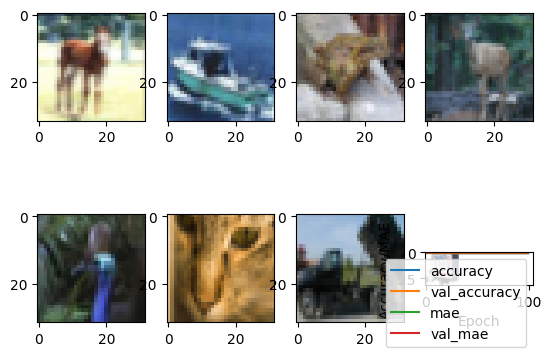

Max accuracy:  0.9175800085067749
Min accuracy:  0.4772000014781952
313/313 [==============================] - 1s 3ms/step - loss: 0.8962 - mae: 0.0482 - accuracy: 0.7914
Test performance  [0.8961658477783203, 0.048227258026599884, 0.7914000153541565]


(<keras.engine.sequential.Sequential at 0x7a2aa4191ab0>,
 <keras.callbacks.History at 0x7a2a1c05a6b0>)

In [3]:
dataaug = ImageDataGenerator()
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100)

Rotating Images

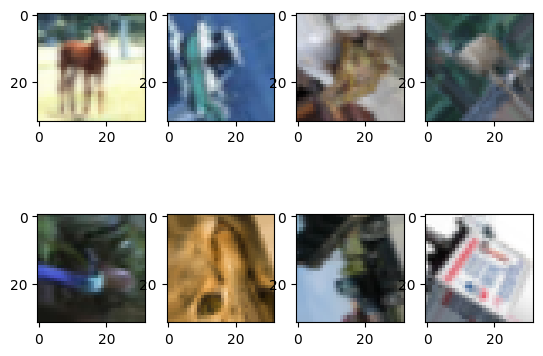

2023-05-03 14:16:29.109824: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/spatial_dropout2d_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


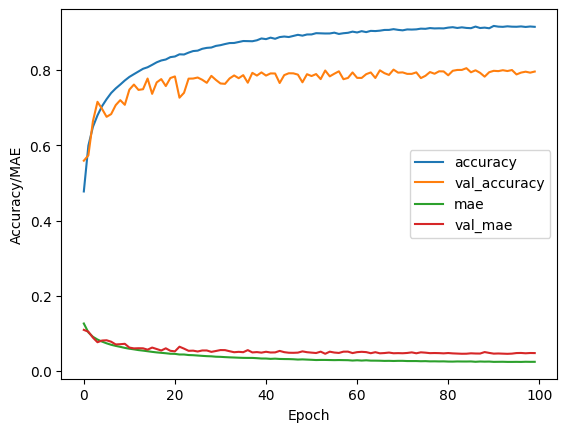

Max accuracy:  0.9170799851417542
Min accuracy:  0.47727999091148376
313/313 [==============================] - 1s 3ms/step - loss: 0.8559 - mae: 0.0479 - accuracy: 0.7959
Test performance  [0.855897068977356, 0.047928337007761, 0.7958999872207642]


(<keras.engine.sequential.Sequential at 0x7a2a1f3f6f50>,
 <keras.callbacks.History at 0x7a29f1539a50>)

In [4]:
dataaug = ImageDataGenerator(rotation_range=540)
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

plt.show()

build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100)

Flip horizontally

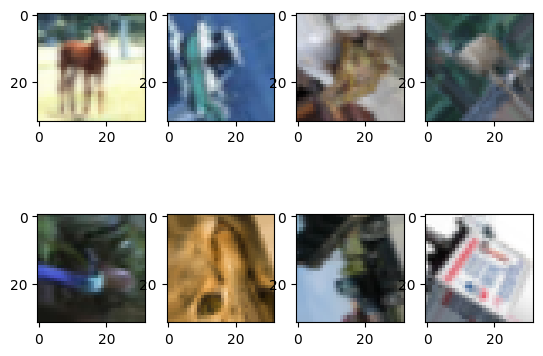

2023-05-03 14:30:57.041433: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/spatial_dropout2d_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


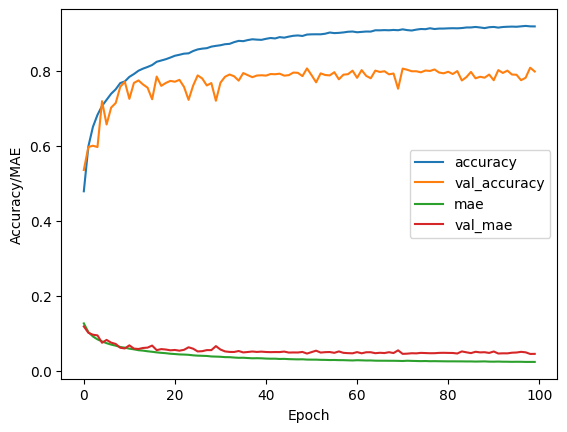

Max accuracy:  0.91948002576828
Min accuracy:  0.4785600006580353
313/313 [==============================] - 1s 3ms/step - loss: 0.8833 - mae: 0.0451 - accuracy: 0.7980
Test performance  [0.8833229541778564, 0.0451001301407814, 0.7979999780654907]


(<keras.engine.sequential.Sequential at 0x7a2a0848cb50>,
 <keras.callbacks.History at 0x7a29c60efc70>)

In [5]:
dataaug = ImageDataGenerator(rotation_range=540)
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

plt.show()

build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100)

Add random noise

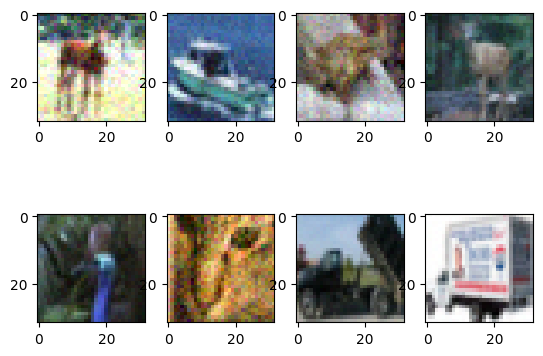

2023-05-03 14:45:35.637188: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/spatial_dropout2d_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


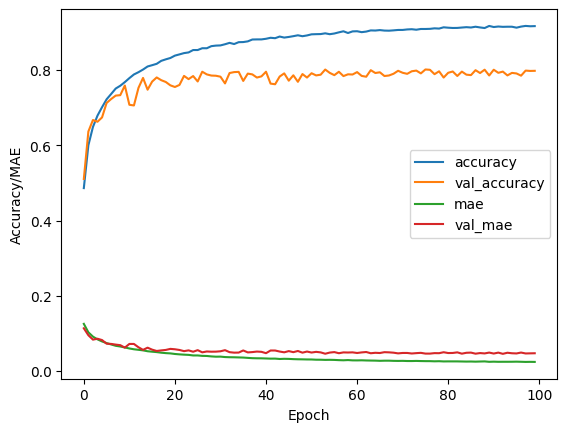

Max accuracy:  0.9174799919128418
Min accuracy:  0.48625999689102173
313/313 [==============================] - 1s 3ms/step - loss: 0.8333 - mae: 0.0472 - accuracy: 0.7981
Test performance  [0.8332741260528564, 0.047168705612421036, 0.7980999946594238]


(<keras.engine.sequential.Sequential at 0x7a29c04a71c0>,
 <keras.callbacks.History at 0x7a2a0814c730>)

In [6]:
def noise(img):
    deviation = 0.08*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

dataaug = ImageDataGenerator(preprocessing_function=noise)
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

plt.show()
build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100)

Apply filter

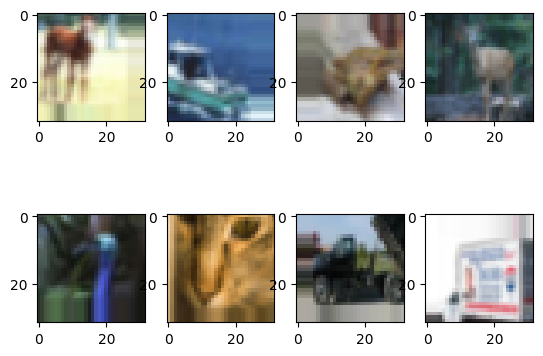

2023-05-03 15:00:16.123774: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/spatial_dropout2d_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


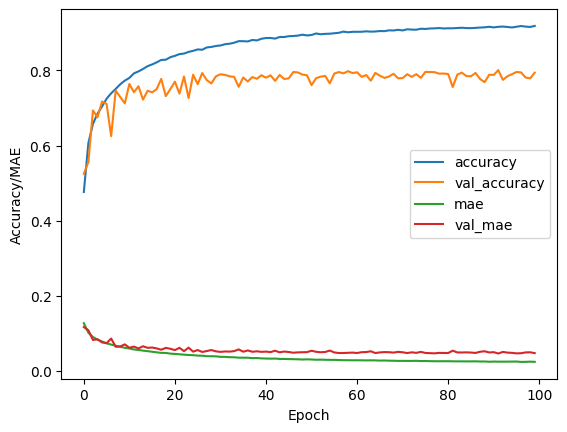

Max accuracy:  0.9187399744987488
Min accuracy:  0.4763199985027313
313/313 [==============================] - 1s 3ms/step - loss: 0.8566 - mae: 0.0471 - accuracy: 0.7943
Test performance  [0.8566007614135742, 0.047101542353630066, 0.7943000197410583]


(<keras.engine.sequential.Sequential at 0x7a29c04a7310>,
 <keras.callbacks.History at 0x7a29c1eac6d0>)

In [7]:
dataaug = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2)
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

plt.show()

build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100)

Zoom

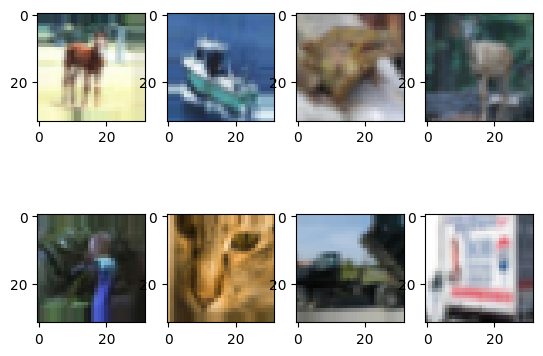

2023-05-03 15:15:44.249679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/spatial_dropout2d_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


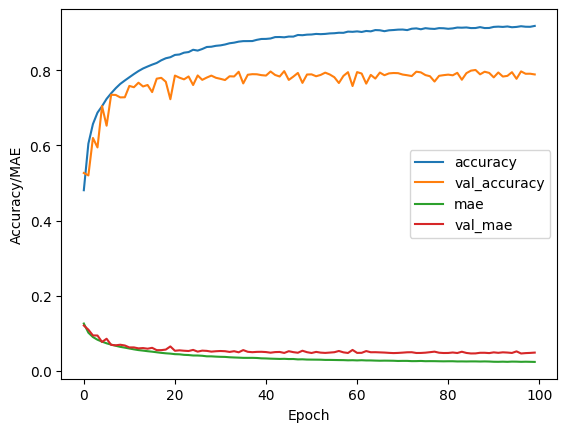

Max accuracy:  0.9182400107383728
Min accuracy:  0.48089998960494995
313/313 [==============================] - 1s 3ms/step - loss: 0.8839 - mae: 0.0487 - accuracy: 0.7891
Test performance  [0.8838853240013123, 0.04868994653224945, 0.7890999913215637]


(<keras.engine.sequential.Sequential at 0x7a29c1a95d80>,
 <keras.callbacks.History at 0x7a29c189ae30>)

In [8]:
dataaug = ImageDataGenerator(zoom_range=0.3)
dataaug.fit(X_train)

sample  = dataaug.flow(X_train, y_train, batch_size=8, seed=100)  
X_batch, y_batch = next(sample)


fig, axs = plt.subplots(2, 4)

axs[0,0].imshow(X_batch[0])
axs[0,1].imshow(X_batch[1])
axs[0,2].imshow(X_batch[2])
axs[0,3].imshow(X_batch[3])
axs[1,0].imshow(X_batch[4])
axs[1,1].imshow(X_batch[5])
axs[1,2].imshow(X_batch[6])
axs[1,3].imshow(X_batch[7])

plt.show()

build_and_plot3(regularizer=l2, lam=0.00001, dropout=True, drop_prob1=0.2, drop_prob2=0.2, e=100)